<a href="https://colab.research.google.com/github/avbarbaros/CLIP/blob/main/CLIP_Demo_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP Model Interactive Demo
## Understanding Contrastive Language-Image Pre-training
---

This notebook provides hands-on demonstrations of CLIP's core capabilities:
1. **Zero-shot image classification**
2. **Image-text similarity computation**
3. **Visualizing the embedding space**
4. **Understanding contrastive learning**

### Learning Objectives
- Understand how CLIP encodes images and text into a joint embedding space
- See zero-shot classification in action
- Visualize similarity matrices (like in the presentation)
- Explore the mathematical foundations interactively

## Part 1: Setup and Installation

First, let's install the required packages and import libraries.

In [1]:
# Install required packages
!pip install torch torchvision ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install matplotlib numpy pillow requests

print("✓ Installation complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.5 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-xo09nn46
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-xo09nn46
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=36950140436edfa7fb1ed25d104ec05f5e699f55f0ce56d30944f0661daeacfb
  Stored in directory: /tmp/pip-ephem-wheel-cache-qtrx43v4/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
✓ Installation complete!


In [2]:
# Import libraries
import torch
import clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import seaborn as sns
from IPython.display import display, HTML

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ Libraries imported successfully!
PyTorch version: 2.9.0+cu126
CUDA available: False


## Part 2: Load CLIP Model

CLIP comes in different sizes. We'll use **ViT-B/32** which is a good balance between performance and speed.

### Model Architecture (from presentation):
- **Image Encoder**: Vision Transformer (ViT)
- **Text Encoder**: Transformer
- **Embedding dimension**: 512

In [3]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

print(f"✓ CLIP model loaded on {device}")
print(f"✓ Model: ViT-B/32")
print(f"✓ Embedding dimension: 512")

# Show available models
print("\nAvailable CLIP models:")
print(clip.available_models())

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 144MiB/s]


✓ CLIP model loaded on cpu
✓ Model: ViT-B/32
✓ Embedding dimension: 512

Available CLIP models:
['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


## Part 3: Helper Functions

Let's create some helper functions for loading images and visualization.

In [4]:
def load_image_from_url(url):
    """
    Load an image from a URL
    """
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

def display_image_with_title(image, title=""):
    """
    Display image with title
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_similarity_matrix(similarities, image_names, text_labels, title="Similarity Matrix"):
    """
    Plot similarity matrix like in the presentation
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create heatmap
    im = ax.imshow(similarities, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

    # Set ticks and labels
    ax.set_xticks(np.arange(len(text_labels)))
    ax.set_yticks(np.arange(len(image_names)))
    ax.set_xticklabels(text_labels, rotation=45, ha='right')
    ax.set_yticklabels(image_names)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Cosine Similarity', rotation=270, labelpad=20)

    # Add text annotations
    for i in range(len(image_names)):
        for j in range(len(text_labels)):
            text = ax.text(j, i, f'{similarities[i, j]:.3f}',
                         ha="center", va="center", color="black", fontweight='bold')

    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Text Labels', fontsize=12, fontweight='bold')
    ax.set_ylabel('Images', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("✓ Helper functions defined!")

✓ Helper functions defined!


## Part 4: DEMO 1 - Zero-Shot Image Classification

### From the Presentation:
This demonstrates the complete CLIP pipeline:
1. **Encode image** → Get image embedding $\mathbf{I}$
2. **Encode text labels** → Get text embeddings $\mathbf{T}_1, \mathbf{T}_2, ...$
3. **Compute similarities** → $s_j = \mathbf{I} \cdot \mathbf{T}_j \times \exp(\tau)$
4. **Apply softmax** → Get probabilities

Let's classify images without any training on those specific categories!

In [5]:
# Example images (you can replace these URLs)
image_urls = [
    "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=400",  # Cat
    "https://images.unsplash.com/photo-1552053831-71594a27632d?w=400",  # Dog
    "https://images.unsplash.com/photo-1552519507-da3b142c6e3d?w=400",  # Car
]

image_descriptions = ["Cat", "Dog", "Car"]

# Candidate labels for classification
candidate_labels = ["cat", "dog", "bird", "car", "airplane", "boat"]

print("Loading images...")
images = [load_image_from_url(url) for url in image_urls]
print(f"✓ Loaded {len(images)} images")

Loading images...
✓ Loaded 3 images


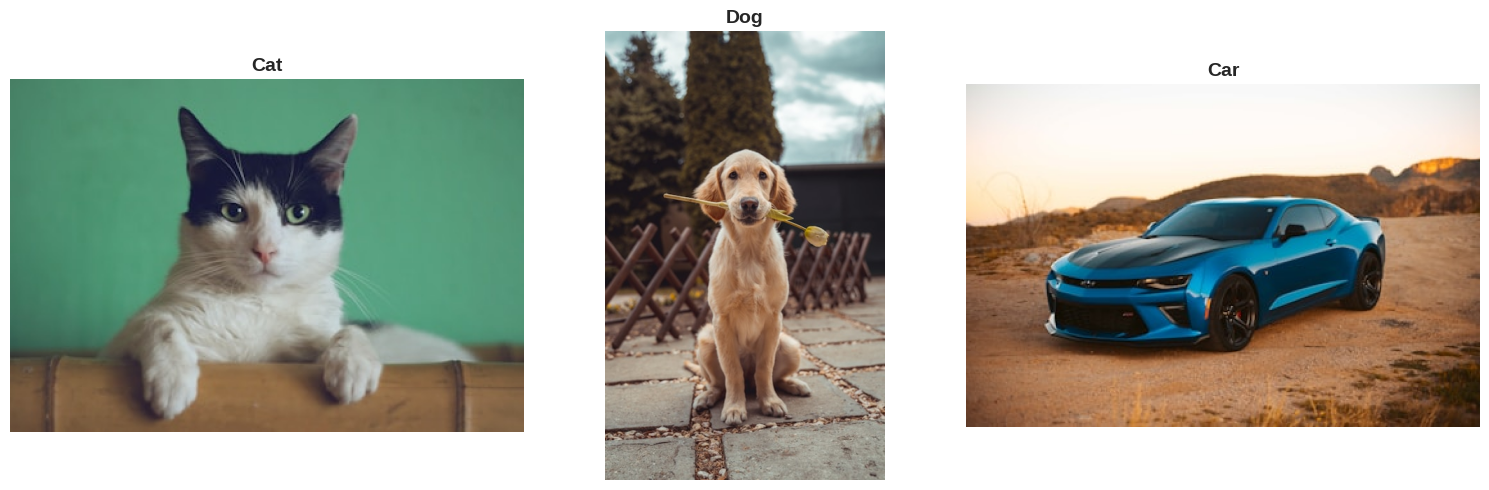

In [6]:
# Display the images
fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
for idx, (img, desc) in enumerate(zip(images, image_descriptions)):
    axes[idx].imshow(img)
    axes[idx].set_title(desc, fontsize=14, fontweight='bold')
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

### Step-by-Step Classification

Now let's perform zero-shot classification step by step, following the mathematical pipeline from the presentation.

In [7]:
# Step 1: Preprocess images and encode
print("Step 1: Encoding images...")
image_inputs = torch.stack([preprocess(img) for img in images]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image_inputs)
    # L2 normalization (from presentation: I = f_I(img) / ||f_I(img)||)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

print(f"✓ Image embeddings shape: {image_features.shape}")
print(f"  (batch_size={len(images)}, embedding_dim=512)")
print(f"✓ Embeddings are L2-normalized (unit vectors)")

Step 1: Encoding images...
✓ Image embeddings shape: torch.Size([3, 512])
  (batch_size=3, embedding_dim=512)
✓ Embeddings are L2-normalized (unit vectors)


In [8]:
# Step 2: Encode text labels
print("\nStep 2: Encoding text labels...")

# Create prompts ("a photo of a {label}" works better than just the label)
text_prompts = [f"a photo of a {label}" for label in candidate_labels]
print(f"Text prompts: {text_prompts}")

text_inputs = clip.tokenize(text_prompts).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    # L2 normalization (from presentation: T = f_T(text) / ||f_T(text)||)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

print(f"✓ Text embeddings shape: {text_features.shape}")
print(f"  (num_labels={len(candidate_labels)}, embedding_dim=512)")


Step 2: Encoding text labels...
Text prompts: ['a photo of a cat', 'a photo of a dog', 'a photo of a bird', 'a photo of a car', 'a photo of a airplane', 'a photo of a boat']
✓ Text embeddings shape: torch.Size([6, 512])
  (num_labels=6, embedding_dim=512)


In [9]:
# Step 3: Compute similarity matrix (from presentation: s_ij = I_i · T_j × exp(τ))
print("\nStep 3: Computing cosine similarities...")

# Get the learnable temperature parameter
temperature = model.logit_scale.exp().item()
print(f"✓ Temperature (τ): {temperature:.4f}")

# Compute similarity matrix: (num_images, num_labels)
similarity_matrix = (image_features @ text_features.T) * temperature

print(f"✓ Similarity matrix shape: {similarity_matrix.shape}")
print(f"  (num_images={len(images)}, num_labels={len(candidate_labels)})")
print(f"\nRaw similarity scores (logits):")
print(similarity_matrix.cpu().numpy())


Step 3: Computing cosine similarities...
✓ Temperature (τ): 100.0000
✓ Similarity matrix shape: torch.Size([3, 6])
  (num_images=3, num_labels=6)

Raw similarity scores (logits):
[[30.264565 25.051592 22.719313 20.34812  18.593029 20.513906]
 [22.513905 28.799328 21.990225 19.828674 19.692003 21.512796]
 [20.824785 19.041504 19.635489 26.197578 18.54976  20.056265]]


In [10]:
# Step 4: Apply softmax to get probabilities
print("\nStep 4: Applying softmax...")

# Softmax: p_j = exp(s_j) / Σ_k exp(s_k)
probabilities = similarity_matrix.softmax(dim=-1).cpu().numpy()

print(f"✓ Probabilities shape: {probabilities.shape}")
print(f"\nProbabilities (each row sums to 1.0):")
print(probabilities)
print(f"\nRow sums (should be 1.0): {probabilities.sum(axis=1)}")


Step 4: Applying softmax...
✓ Probabilities shape: (3, 6)

Probabilities (each row sums to 1.0):
[[9.93946612e-01 5.41249849e-03 5.25414187e-04 4.90575439e-05
  8.48163472e-06 5.79036678e-05]
 [1.85604894e-03 9.96125519e-01 1.09940628e-03 1.26592713e-04
  1.10421395e-04 6.82045997e-04]
 [4.59764060e-03 7.72797561e-04 1.39968400e-03 9.90625381e-01
  4.72611719e-04 2.13191984e-03]]

Row sums (should be 1.0): [0.99999994 1.         1.        ]


### Visualize Results: Similarity Matrix

This is similar to the N×N matrix shown in the presentation for contrastive learning!

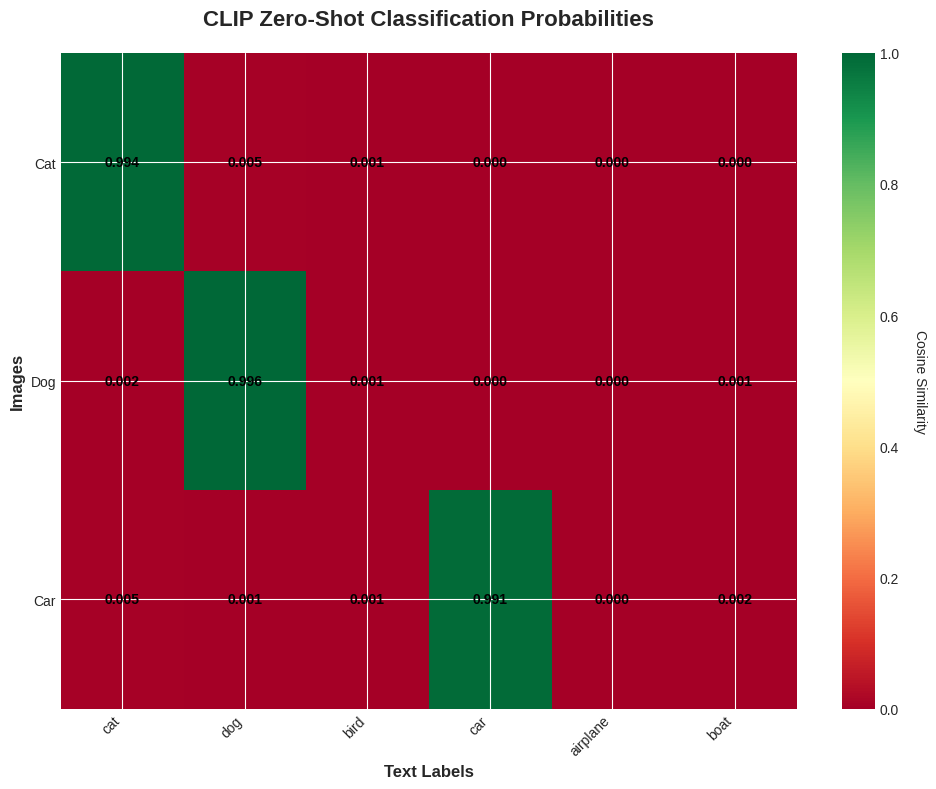

In [11]:
# Plot similarity matrix
plot_similarity_matrix(
    probabilities,
    image_descriptions,
    candidate_labels,
    title="CLIP Zero-Shot Classification Probabilities"
)

In [12]:
# Show detailed results for each image
print("\n" + "="*60)
print("ZERO-SHOT CLASSIFICATION RESULTS")
print("="*60)

for idx, (img_desc, probs) in enumerate(zip(image_descriptions, probabilities)):
    print(f"\n🖼️  Image {idx+1}: {img_desc}")
    print("-" * 50)

    # Sort by probability
    sorted_indices = np.argsort(probs)[::-1]

    for rank, label_idx in enumerate(sorted_indices, 1):
        label = candidate_labels[label_idx]
        prob = probs[label_idx]

        # Highlight top prediction
        if rank == 1:
            print(f"  🏆 #{rank}: {label:15s} - {prob*100:6.2f}% ⭐ TOP PREDICTION")
        else:
            print(f"     #{rank}: {label:15s} - {prob*100:6.2f}%")


ZERO-SHOT CLASSIFICATION RESULTS

🖼️  Image 1: Cat
--------------------------------------------------
  🏆 #1: cat             -  99.39% ⭐ TOP PREDICTION
     #2: dog             -   0.54%
     #3: bird            -   0.05%
     #4: boat            -   0.01%
     #5: car             -   0.00%
     #6: airplane        -   0.00%

🖼️  Image 2: Dog
--------------------------------------------------
  🏆 #1: dog             -  99.61% ⭐ TOP PREDICTION
     #2: cat             -   0.19%
     #3: bird            -   0.11%
     #4: boat            -   0.07%
     #5: car             -   0.01%
     #6: airplane        -   0.01%

🖼️  Image 3: Car
--------------------------------------------------
  🏆 #1: car             -  99.06% ⭐ TOP PREDICTION
     #2: cat             -   0.46%
     #3: boat            -   0.21%
     #4: bird            -   0.14%
     #5: dog             -   0.08%
     #6: airplane        -   0.05%


## Part 5: DEMO 2 - Understanding the Embedding Space

### Mathematical Foundation (from presentation):
- Both images and text are mapped to the same 512-dimensional space
- L2 normalization ensures they lie on a unit hypersphere
- Cosine similarity measures alignment

Let's visualize how embeddings cluster!

In [13]:
# Let's explore more concepts
concepts = [
    # Animals
    "a photo of a cat",
    "a photo of a dog",
    "a photo of a tiger",
    "a photo of a lion",

    # Vehicles
    "a photo of a car",
    "a photo of a truck",
    "a photo of a motorcycle",
    "a photo of a bicycle",

    # Nature
    "a photo of a tree",
    "a photo of a flower",
    "a photo of a mountain",
    "a photo of a beach",
]

# Encode all concepts
text_inputs = clip.tokenize(concepts).to(device)

with torch.no_grad():
    concept_features = model.encode_text(text_inputs)
    concept_features = concept_features / concept_features.norm(dim=-1, keepdim=True)

print(f"✓ Encoded {len(concepts)} concepts")
print(f"✓ Embedding shape: {concept_features.shape}")

✓ Encoded 12 concepts
✓ Embedding shape: torch.Size([12, 512])


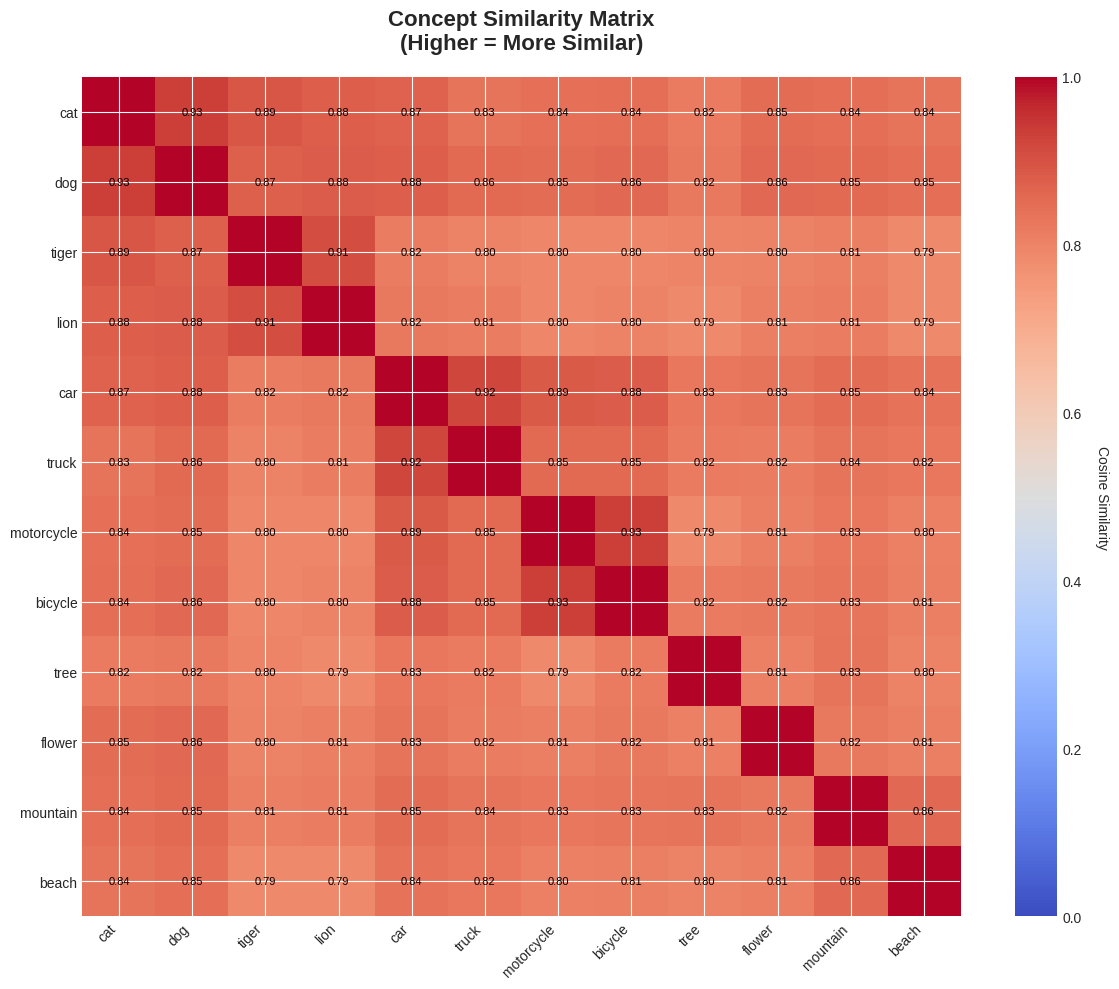


🔍 Observations:
  • Animals cluster together (cat, dog, tiger, lion)
  • Vehicles cluster together (car, truck, motorcycle, bicycle)
  • Nature concepts cluster together (tree, flower, mountain, beach)
  • This shows CLIP learned semantic relationships!


In [14]:
# Compute pairwise similarities between all concepts
concept_similarity = (concept_features @ concept_features.T).cpu().numpy()

# Create labels (remove "a photo of a" for display)
concept_labels = [c.replace("a photo of a ", "") for c in concepts]

# Plot similarity matrix
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(concept_similarity, cmap='coolwarm', aspect='auto', vmin=0, vmax=1)

# Set ticks
ax.set_xticks(np.arange(len(concept_labels)))
ax.set_yticks(np.arange(len(concept_labels)))
ax.set_xticklabels(concept_labels, rotation=45, ha='right')
ax.set_yticklabels(concept_labels)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Cosine Similarity', rotation=270, labelpad=20)

# Add text annotations (smaller for readability)
for i in range(len(concepts)):
    for j in range(len(concepts)):
        if i != j:  # Don't show diagonal (always 1.0)
            text = ax.text(j, i, f'{concept_similarity[i, j]:.2f}',
                         ha="center", va="center", color="black", fontsize=8)

ax.set_title('Concept Similarity Matrix\n(Higher = More Similar)',
             fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n🔍 Observations:")
print("  • Animals cluster together (cat, dog, tiger, lion)")
print("  • Vehicles cluster together (car, truck, motorcycle, bicycle)")
print("  • Nature concepts cluster together (tree, flower, mountain, beach)")
print("  • This shows CLIP learned semantic relationships!")

## Part 6: DEMO 3 - Interactive Classification

Now you can classify any image from a URL with custom labels!

In [15]:
def classify_image_interactive(image_url, custom_labels):
    """
    Classify an image with custom labels
    """
    # Load and display image
    print("Loading image...")
    image = load_image_from_url(image_url)
    display_image_with_title(image, "Input Image")

    # Preprocess and encode image
    image_input = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_input)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    # Encode text labels
    text_prompts = [f"a photo of a {label}" for label in custom_labels]
    text_inputs = clip.tokenize(text_prompts).to(device)

    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # Compute similarities and probabilities
    temperature = model.logit_scale.exp().item()
    similarity = (image_features @ text_features.T) * temperature
    probs = similarity.softmax(dim=-1).cpu().numpy()[0]

    # Display results
    print("\n" + "="*60)
    print("CLASSIFICATION RESULTS")
    print("="*60)

    sorted_indices = np.argsort(probs)[::-1]

    for rank, idx in enumerate(sorted_indices, 1):
        label = custom_labels[idx]
        prob = probs[idx]

        # Create bar
        bar_length = int(prob * 50)
        bar = "█" * bar_length + "░" * (50 - bar_length)

        if rank == 1:
            print(f"\n🏆 {label:20s} {prob*100:6.2f}% {bar}")
        else:
            print(f"   {label:20s} {prob*100:6.2f}% {bar}")

    # Create bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['green' if i == sorted_indices[0] else 'steelblue' for i in range(len(custom_labels))]

    sorted_labels = [custom_labels[i] for i in sorted_indices]
    sorted_probs = [probs[i] for i in sorted_indices]

    bars = ax.barh(sorted_labels, sorted_probs, color=colors)
    ax.set_xlabel('Probability', fontsize=12, fontweight='bold')
    ax.set_title('Classification Probabilities', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1)

    # Add value labels
    for i, (label, prob) in enumerate(zip(sorted_labels, sorted_probs)):
        ax.text(prob + 0.02, i, f'{prob*100:.1f}%',
               va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    return probs

### Try it yourself!

**Example 1: Animal Classification**

Loading image...


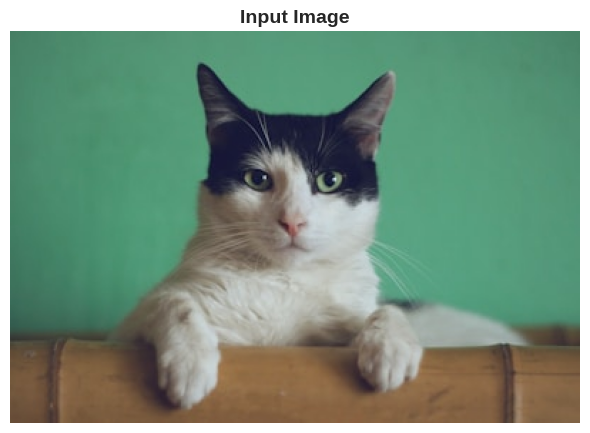


CLASSIFICATION RESULTS

🏆 cat                   99.25% █████████████████████████████████████████████████░
   dog                    0.54% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   horse                  0.14% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   bird                   0.05% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   elephant               0.01% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░


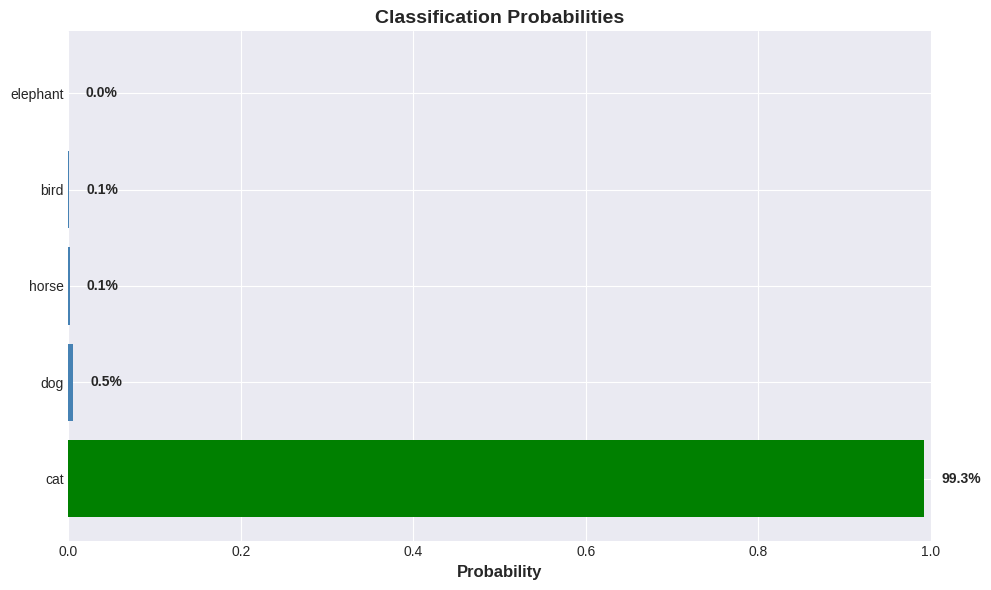

In [16]:
# Example: Classify a cat image
image_url = "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=400"
labels = ["cat", "dog", "bird", "horse", "elephant"]

probs = classify_image_interactive(image_url, labels)

**Example 2: Try your own image!**

Replace the URL and labels below:

Loading image...


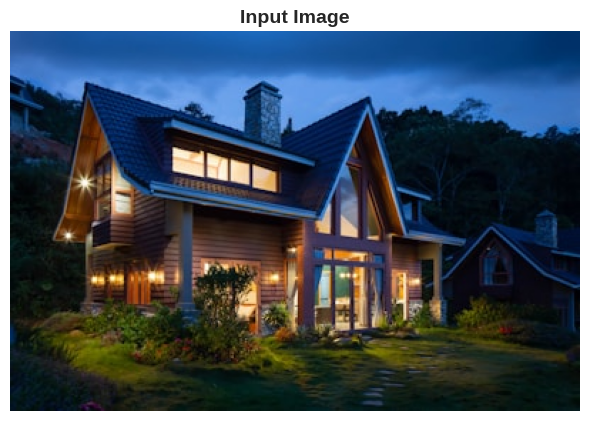


CLASSIFICATION RESULTS

🏆 cabin                 72.05% ████████████████████████████████████░░░░░░░░░░░░░░
   residence             14.15% ███████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   house                 13.64% ██████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   apartment              0.16% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   bicycle                0.00% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   car                    0.00% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░


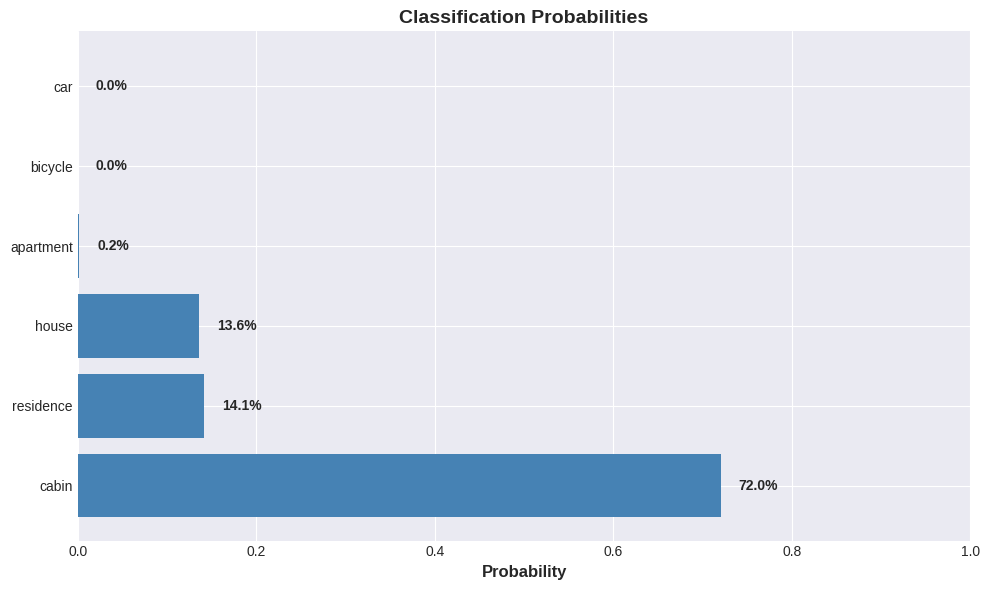

In [19]:
# YOUR CUSTOM IMAGE AND LABELS
my_image_url = "https://images.unsplash.com/photo-1568605114967-8130f3a36994?w=400"  # Car
# my_labels = ["car", "bicycle", "motorcycle", "truck", "bus", "train"]
my_labels = ["car", "bicycle", "apartment", "residence", "house", "cabin"]

probs = classify_image_interactive(my_image_url, my_labels)

## Part 7: Understanding Contrastive Loss

### From the Presentation:
$$\mathcal{L} = -\log \frac{\exp(s_{i,i})}{\sum_j \exp(s_{i,j})}$$

Let's visualize what this loss function does!

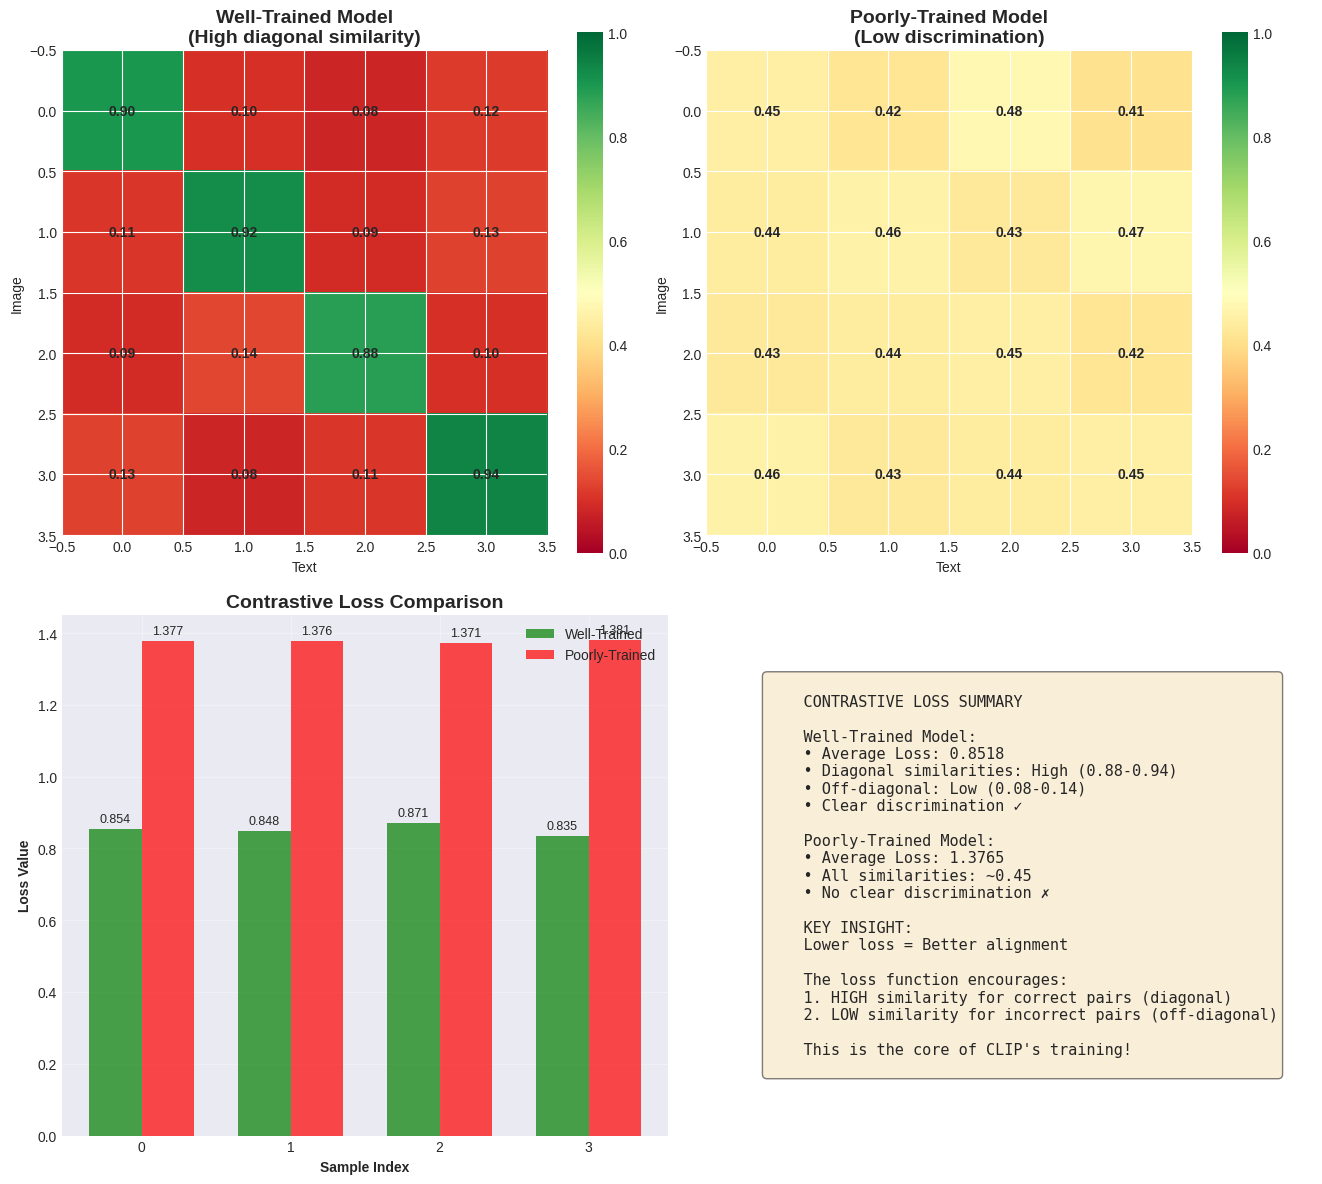

In [ ]:
def visualize_contrastive_loss():
    """
    Visualize how contrastive loss works
    """
    # Simulate a small batch (N=4)
    N = 4

    # Create similarity matrix (correct pairs have high similarity)
    # This simulates: s_ij = I_i · T_j
    similarity_good = np.array([
        [0.90, 0.10, 0.08, 0.12],  # Image 1 matches Text 1
        [0.11, 0.92, 0.09, 0.13],  # Image 2 matches Text 2
        [0.09, 0.14, 0.88, 0.10],  # Image 3 matches Text 3
        [0.13, 0.08, 0.11, 0.94],  # Image 4 matches Text 4
    ])

    similarity_bad = np.array([
        [0.45, 0.42, 0.48, 0.41],  # Image 1 poorly discriminated
        [0.44, 0.46, 0.43, 0.47],  # Image 2 poorly discriminated
        [0.43, 0.44, 0.45, 0.42],  # Image 3 poorly discriminated
        [0.46, 0.43, 0.44, 0.45],  # Image 4 poorly discriminated
    ])

    # Compute losses
    def compute_contrastive_loss(sim_matrix):
        losses = []
        for i in range(N):
            # Loss for image i: -log(exp(s_ii) / sum_j(exp(s_ij)))
            numerator = np.exp(sim_matrix[i, i])
            denominator = np.sum(np.exp(sim_matrix[i, :]))
            loss = -np.log(numerator / denominator)
            losses.append(loss)
        return np.array(losses)

    loss_good = compute_contrastive_loss(similarity_good)
    loss_bad = compute_contrastive_loss(similarity_bad)

    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # Good similarity matrix
    im1 = axes[0, 0].imshow(similarity_good, cmap='RdYlGn', vmin=0, vmax=1)
    axes[0, 0].set_title('Well-Trained Model\n(High diagonal similarity)',
                        fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Text')
    axes[0, 0].set_ylabel('Image')

    for i in range(N):
        for j in range(N):
            axes[0, 0].text(j, i, f'{similarity_good[i, j]:.2f}',
                          ha='center', va='center', fontweight='bold')

    plt.colorbar(im1, ax=axes[0, 0])

    # Bad similarity matrix
    im2 = axes[0, 1].imshow(similarity_bad, cmap='RdYlGn', vmin=0, vmax=1)
    axes[0, 1].set_title('Poorly-Trained Model\n(Low discrimination)',
                        fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Text')
    axes[0, 1].set_ylabel('Image')

    for i in range(N):
        for j in range(N):
            axes[0, 1].text(j, i, f'{similarity_bad[i, j]:.2f}',
                          ha='center', va='center', fontweight='bold')

    plt.colorbar(im2, ax=axes[0, 1])

    # Loss comparison
    x = np.arange(N)
    width = 0.35

    axes[1, 0].bar(x - width/2, loss_good, width, label='Well-Trained', color='green', alpha=0.7)
    axes[1, 0].bar(x + width/2, loss_bad, width, label='Poorly-Trained', color='red', alpha=0.7)
    axes[1, 0].set_xlabel('Sample Index', fontweight='bold')
    axes[1, 0].set_ylabel('Loss Value', fontweight='bold')
    axes[1, 0].set_title('Contrastive Loss Comparison', fontsize=14, fontweight='bold')
    axes[1, 0].set_xticks(x)
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)

    # Add value labels
    for i, (lg, lb) in enumerate(zip(loss_good, loss_bad)):
        axes[1, 0].text(i - width/2, lg + 0.02, f'{lg:.3f}', ha='center', fontsize=9)
        axes[1, 0].text(i + width/2, lb + 0.02, f'{lb:.3f}', ha='center', fontsize=9)

    # Summary statistics
    axes[1, 1].axis('off')
    summary_text = f"""
    CONTRASTIVE LOSS SUMMARY

    Well-Trained Model:
    • Average Loss: {loss_good.mean():.4f}
    • Diagonal similarities: High (0.88-0.94)
    • Off-diagonal: Low (0.08-0.14)
    • Clear discrimination ✓

    Poorly-Trained Model:
    • Average Loss: {loss_bad.mean():.4f}
    • All similarities: ~0.45
    • No clear discrimination ✗

    KEY INSIGHT:
    Lower loss = Better alignment

    The loss function encourages:
    1. HIGH similarity for correct pairs (diagonal)
    2. LOW similarity for incorrect pairs (off-diagonal)

    This is the core of CLIP's training!
    """

    axes[1, 1].text(0.1, 0.5, summary_text,
                   transform=axes[1, 1].transAxes,
                   fontsize=11,
                   verticalalignment='center',
                   fontfamily='monospace',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

# Run visualization
visualize_contrastive_loss()

## Part 8: Key Insights and Takeaways

### What We Learned:

1. **Zero-Shot Classification**: CLIP can classify images into ANY categories without training on them

2. **Joint Embedding Space**: Images and text are mapped to the same 512-dimensional space

3. **Mathematical Foundation**:
   - Embeddings: $\mathbf{I} = \frac{f_I(\text{img})}{\|f_I(\text{img})\|}$
   - Similarity: $s_{i,j} = \mathbf{I}_i \cdot \mathbf{T}_j \times \exp(\tau)$
   - Loss: $\mathcal{L} = -\log \frac{\exp(s_{i,i})}{\sum_j \exp(s_{i,j})}$

4. **Contrastive Learning**: Maximizes similarity for correct pairs, minimizes for incorrect pairs

5. **Semantic Understanding**: CLIP learns meaningful relationships between concepts

### From the Presentation:
- **Training Data**: 400M image-text pairs
- **Batch Size**: 32,768 (enables strong contrastive learning)
- **Architecture**: Dual encoders (ViT + Transformer)
- **Impact**: Foundation for DALL-E, Stable Diffusion, GPT-4V

## Part 9: Exercise - Try Different Scenarios



EXERCISE 1: Dog Breed Classification
Loading image...


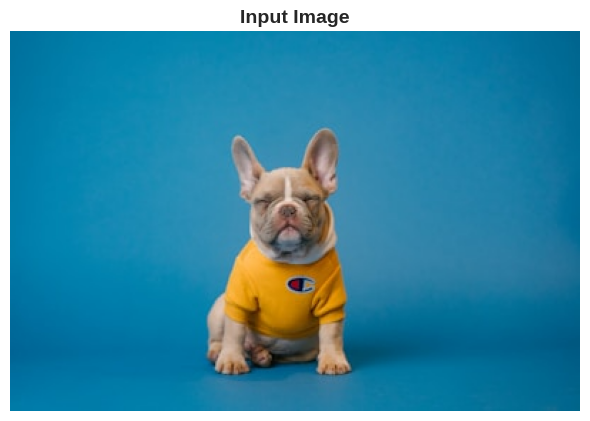


CLASSIFICATION RESULTS

🏆 bulldog               98.55% █████████████████████████████████████████████████░
   golden retriever       0.55% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   poodle                 0.47% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   labrador               0.33% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   german shepherd        0.06% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   husky                  0.03% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░


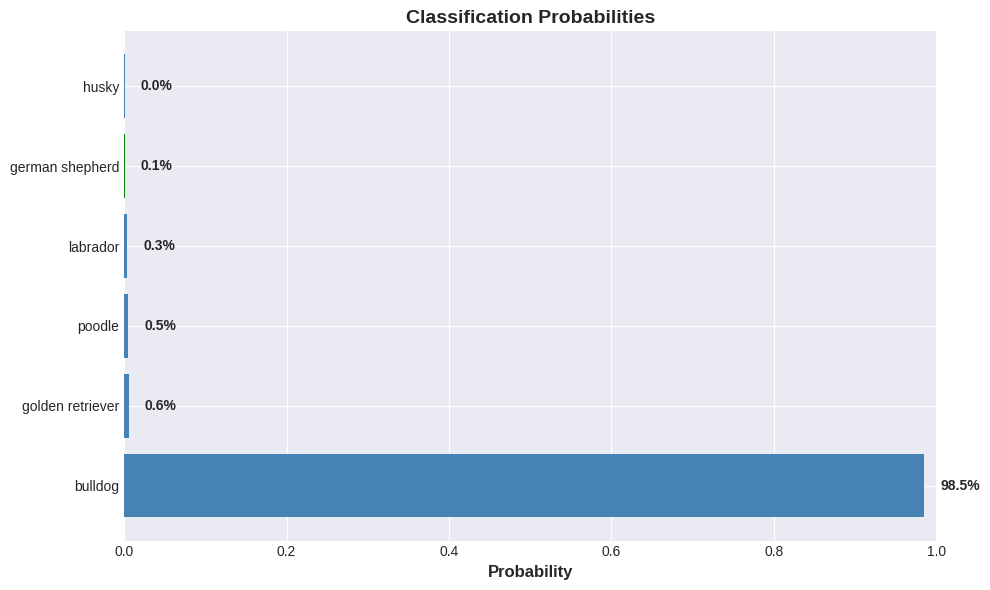

array([5.5224281e-03, 3.3233734e-03, 6.2547927e-04, 4.7220336e-03,
       9.8547596e-01, 3.3070956e-04], dtype=float32)

In [ ]:
# EXERCISE 1: Fine-grained classification
# Try classifying different dog breeds

dog_image_url = "https://images.unsplash.com/photo-1583511655857-d19b40a7a54e?w=400"  # Golden Retriever
dog_breeds = ["golden retriever", "labrador", "german shepherd", "poodle", "bulldog", "husky"]

print("EXERCISE 1: Dog Breed Classification")
print("="*60)
classify_image_interactive(dog_image_url, dog_breeds)


EXERCISE 2: Scene Classification
Loading image...


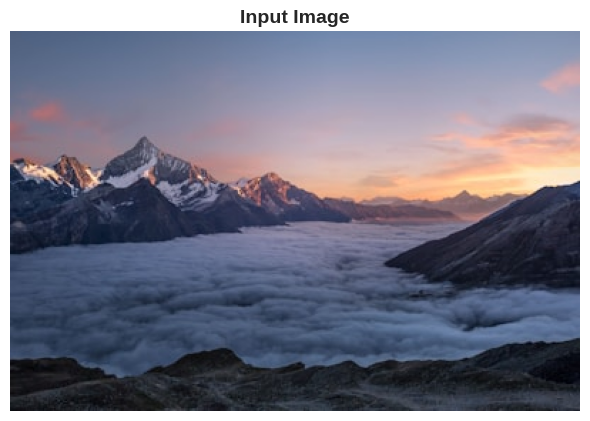


CLASSIFICATION RESULTS

🏆 mountain              73.81% ████████████████████████████████████░░░░░░░░░░░░░░
   fog                   24.07% ████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   countryside            1.07% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   city                   0.60% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   desert                 0.40% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   forest                 0.04% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░


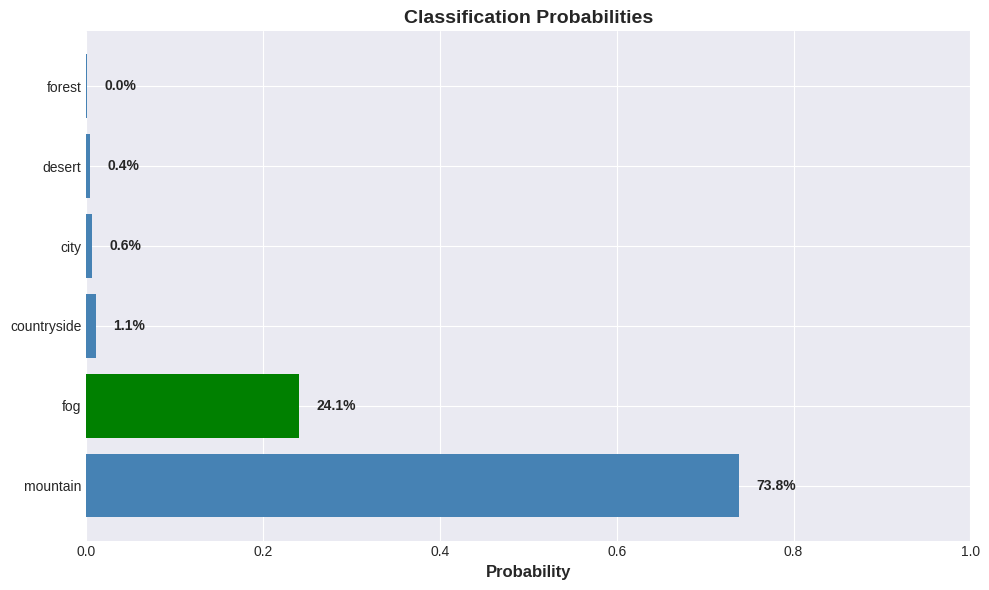

array([2.4072495e-01, 7.3813093e-01, 4.3626022e-04, 4.0078047e-03,
       6.0352883e-03, 1.0664693e-02], dtype=float32)

In [20]:
# EXERCISE 2: Scene classification
# Try classifying different scenes

scene_url = "https://images.unsplash.com/photo-1506905925346-21bda4d32df4?w=400"  # Mountain
scenes = ["fog", "mountain", "forest", "desert", "city", "countryside"]

print("\nEXERCISE 2: Scene Classification")
print("="*60)
classify_image_interactive(scene_url, scenes)


EXERCISE 3: Activity Classification
Loading image...


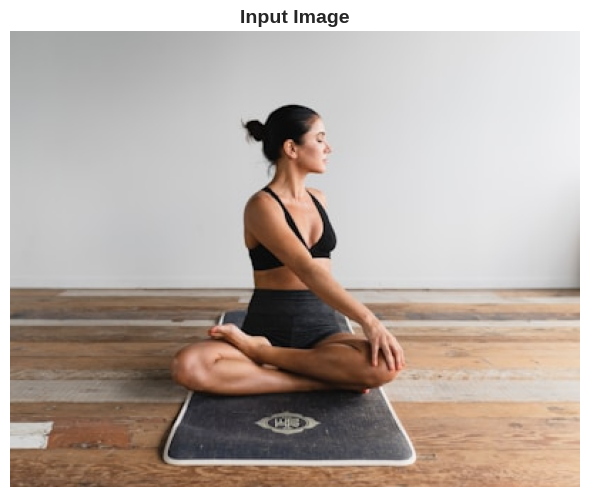


CLASSIFICATION RESULTS

🏆 sitting               83.95% █████████████████████████████████████████░░░░░░░░░
   exercising            15.64% ███████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   jumping                0.14% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   running                0.12% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   cycling                0.12% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   swimming               0.03% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░


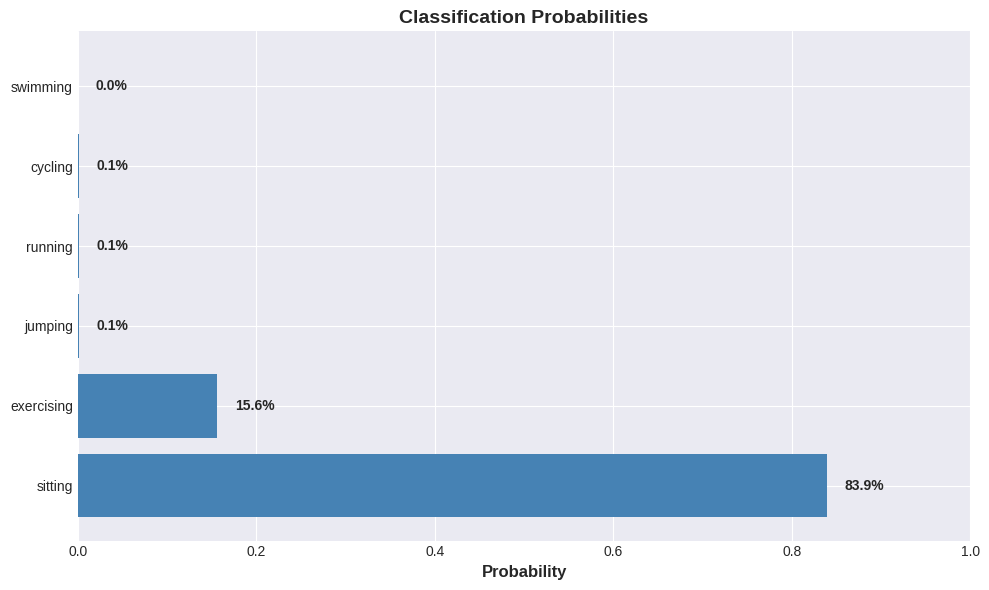

array([1.2227650e-03, 1.5639329e-01, 3.3595684e-04, 1.1521329e-03,
       1.4449634e-03, 8.3945096e-01], dtype=float32)

In [21]:
# EXERCISE 3: Activity classification
# Try classifying human activities

activity_url = "https://images.unsplash.com/photo-1552196563-55cd4e45efb3?w=400"  # Running
# activity_url = "https://unsplash.com/photos/man-doing-butterfly-stroke-JjUyjE-oEbM"
activities = ["running", "exercising", "swimming", "cycling", "jumping", "sitting"]

print("\nEXERCISE 3: Activity Classification")
print("="*60)
classify_image_interactive(activity_url, activities)

## Part 10: Limitations and Challenges

### From the Presentation:

CLIP has some limitations:
1. **Fine-grained tasks**: Struggles with very similar categories
2. **Counting**: Cannot accurately count objects
3. **Spatial relationships**: Limited understanding of "left", "right", "above", etc.
4. **Abstract concepts**: Better with concrete, visual concepts

Let's test some of these:

Testing Spatial Understanding:
(CLIP often struggles with spatial relationships)

Loading image...


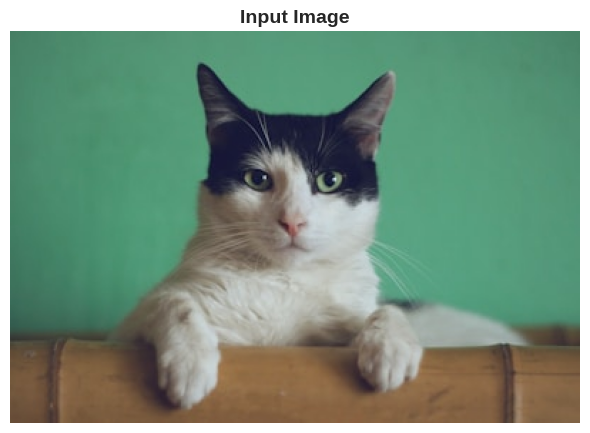


CLASSIFICATION RESULTS

🏆 a cat sitting on a table  52.70% ██████████████████████████░░░░░░░░░░░░░░░░░░░░░░░░
   a table sitting on a cat  29.27% ██████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   a cat staring to a camera  18.03% █████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   a blue sphere on top of a red cube   0.00% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   a red cube on top of a blue sphere   0.00% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░


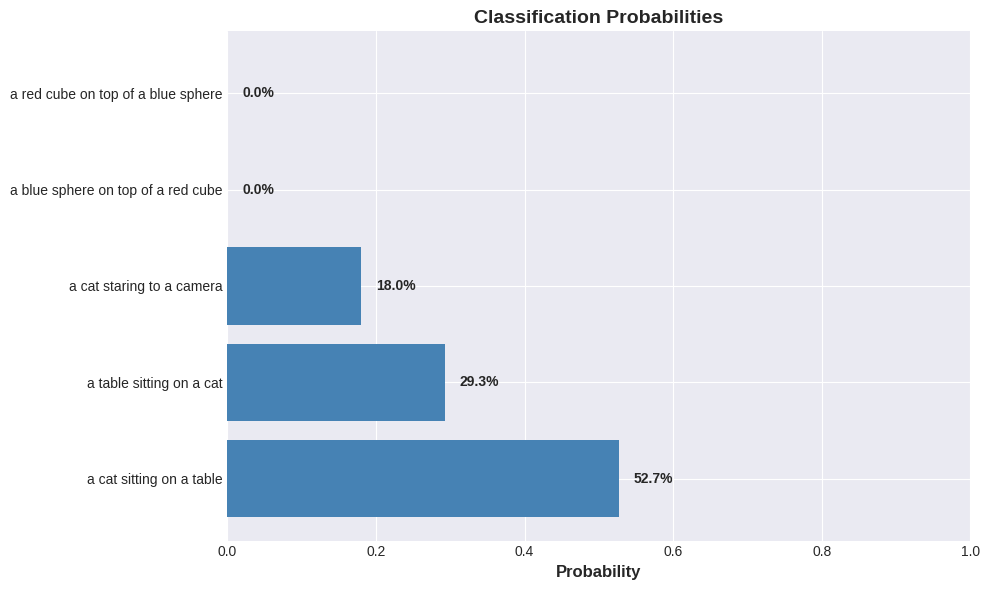

array([1.5586545e-07, 3.6185375e-07, 1.8033029e-01, 5.2700609e-01,
       2.9266307e-01], dtype=float32)

In [23]:
# Test spatial relationships
spatial_url = "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=400"  # Cat

# These are intentionally tricky
spatial_labels = [
    "a red cube on top of a blue sphere",
    "a blue sphere on top of a red cube",
    "a cat staring to a camera",
    "a cat sitting on a table",
    "a table sitting on a cat",
]

print("Testing Spatial Understanding:")
print("(CLIP often struggles with spatial relationships)\n")
classify_image_interactive(spatial_url, spatial_labels)

## Conclusion

### Summary

In this notebook, we:

✅ **Loaded and used CLIP** for zero-shot classification  
✅ **Understood the pipeline**: Image encoding → Text encoding → Similarity → Softmax  
✅ **Visualized embeddings** and similarity matrices  
✅ **Explored contrastive learning** mathematically  
✅ **Tested limitations** and edge cases

### Key Mathematical Concepts (from presentation):

```
1. Embedding:     I = f_I(img) / ||f_I(img)||
2. Similarity:    s_ij = I_i · T_j × exp(τ)
3. Loss:          L = -log(exp(s_ii) / Σ_j exp(s_ij))
4. Training:      400M pairs, batch size 32,768
```

### Why CLIP Matters:

- 🎯 **Zero-shot learning**: No task-specific training needed
- 🌐 **Flexible**: Works with arbitrary text descriptions
- 🏗️ **Foundation**: Enables DALL-E, Stable Diffusion, GPT-4V
- 📊 **Simple**: Clean architecture that scales

---
